# Model Building and Analysis, 2014 to 2023 Data

In [69]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [70]:
df = pd.read_csv('hdb-price-with-features-2014to2023.csv').iloc[:, 1:]
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured
0,2023-03-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,65.833333,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
1,2022-11-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 03,120.0,Improved,1989,66.166667,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
2,2022-10-01,BISHAN,5 ROOM,450,SIN MING AVE,04 TO 06,125.0,Improved,1989,66.250000,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
3,2022-09-01,BISHAN,EXECUTIVE,450,SIN MING AVE,22 TO 24,162.0,Maisonette,1989,66.333333,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
4,2022-09-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,66.333333,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1


In [71]:
cpi = pd.read_csv('monthly cpi.csv')
cpi = cpi.set_index('Data Series')
cpi_data = pd.DataFrame(cpi.columns, columns=['month'])
cpi_data['CPI'] = pd.to_numeric(np.array(cpi.loc['All Items']))
cpi_data = cpi_data.iloc[1: , :]
cpi_data['month'] = pd.to_datetime(cpi_data['month'])

cpi_data.head()

,month,CPI
1,2023-01-01,111.397
2,2022-12-01,111.186
3,2022-11-01,110.959
4,2022-10-01,109.893
5,2022-09-01,110.339


In [72]:
cpi_data.dtypes

month    datetime64[ns]
CPI             float64
dtype: object

In [73]:
df['month'] = pd.to_datetime(df['month'])
df = pd.merge(df, cpi_data, how = 'left')
df['adjusted_price'] = (df['resale_price'] / df['CPI'].fillna(100))*100
df['year'] = pd.DatetimeIndex(df['month']).year
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,CPI,adjusted_price,year
0,2023-03-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,65.833333,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,NaN,9.000000e+05,2023
1,2022-11-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 03,120.0,Improved,1989,66.166667,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,110.959,6.849377e+05,2022
2,2022-10-01,BISHAN,5 ROOM,450,SIN MING AVE,04 TO 06,125.0,Improved,1989,66.250000,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,109.893,7.534602e+05,2022
3,2022-09-01,BISHAN,EXECUTIVE,450,SIN MING AVE,22 TO 24,162.0,Maisonette,1989,66.333333,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,110.339,1.101152e+06,2022
4,2022-09-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,66.333333,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,110.339,7.866665e+05,2022


In [74]:
df.isna().sum()

month                           0
town                            0
flat_type                       0
block                           0
street_name                     0
storey_range                    0
floor_area_sqm                  0
flat_model                      0
lease_commence_date             0
remaining_lease                 0
resale_price                    0
address                         0
latitude                        0
longitude                       0
shortest_dist_mrt_name          0
shortest_dist_mrt               0
mrt_count_within_1km            0
mrt_list_within_1km             0
shortest_dist_mall_name         0
shortest_dist_mall              0
mall_count_within_1km           0
mall_list_within_1km            0
school_shortest_dist            0
school_shortest_dist_name       0
good_sch_count_within_1km       0
good_sch_list_within_1km        0
good_sch_score                  0
good_sch_score_sap_gep          0
distance_to_cbd_km              0
matured       

In [75]:
df['CPI'].dropna()

1         110.959
2         109.893
3         110.339
4         110.339
5         106.547
           ...   
200004     99.342
200005     99.749
200006     99.749
200007     99.749
200008     99.484
Name: CPI, Length: 197602, dtype: float64

In [76]:
# Remove NA values, for march 2023 data
df = df.dropna()

In [77]:
df.isna().sum()

month                        0
town                         0
flat_type                    0
block                        0
street_name                  0
storey_range                 0
floor_area_sqm               0
flat_model                   0
lease_commence_date          0
remaining_lease              0
resale_price                 0
address                      0
latitude                     0
longitude                    0
shortest_dist_mrt_name       0
shortest_dist_mrt            0
mrt_count_within_1km         0
mrt_list_within_1km          0
shortest_dist_mall_name      0
shortest_dist_mall           0
mall_count_within_1km        0
mall_list_within_1km         0
school_shortest_dist         0
school_shortest_dist_name    0
good_sch_count_within_1km    0
good_sch_list_within_1km     0
good_sch_score               0
good_sch_score_sap_gep       0
distance_to_cbd_km           0
matured                      0
CPI                          0
adjusted_price               0
year    

In [78]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'latitude', 'longitude',
       'shortest_dist_mrt_name', 'shortest_dist_mrt', 'mrt_count_within_1km',
       'mrt_list_within_1km', 'shortest_dist_mall_name', 'shortest_dist_mall',
       'mall_count_within_1km', 'mall_list_within_1km', 'school_shortest_dist',
       'school_shortest_dist_name', 'good_sch_count_within_1km',
       'good_sch_list_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'CPI', 'adjusted_price', 'year'],
      dtype='object')

In [79]:
data = df.drop(['month','block', 'street_name', 'lease_commence_date',
                'resale_price','address', 'latitude', 'longitude',
                'shortest_dist_mrt_name', 'mrt_list_within_1km',
                'shortest_dist_mall_name','mall_list_within_1km',
                'school_shortest_dist_name', 'good_sch_list_within_1km', 'CPI'],
               axis = 1)
data.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
1,BISHAN,5 ROOM,01 TO 03,120.0,Improved,66.166667,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,6.849377e+05,2022
2,BISHAN,5 ROOM,04 TO 06,125.0,Improved,66.250000,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,7.534602e+05,2022
3,BISHAN,EXECUTIVE,22 TO 24,162.0,Maisonette,66.333333,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,1.101152e+06,2022
4,BISHAN,5 ROOM,16 TO 18,125.0,Improved,66.333333,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,7.866665e+05,2022
5,BISHAN,5 ROOM,16 TO 18,125.0,Improved,66.750000,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,7.977700e+05,2022


In [80]:
# label encoding for Storey Range
# The higher the storey_range, the higher the label encoding
le = LabelEncoder()
data = data.sort_values(by='storey_range')
data['storey_range'] = le.fit_transform(data['storey_range'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
1,BISHAN,5 ROOM,0,120.0,Improved,66.166667,0.516883,2,0.441609,2,0.381927,1,1,1,8.140460,1,6.849377e+05,2022
94771,BISHAN,4 ROOM,0,84.0,Simplified,68.000000,0.523495,2,0.434649,1,0.179715,1,1,0,6.510500,1,3.750025e+05,2016
94772,BISHAN,4 ROOM,0,90.0,Simplified,69.000000,0.523495,2,0.434649,1,0.179715,1,1,0,6.510500,1,4.327122e+05,2015
94774,BISHAN,4 ROOM,0,84.0,Simplified,71.000000,0.523495,2,0.434649,1,0.179715,1,1,0,6.510500,1,4.469981e+05,2014
94776,BISHAN,5 ROOM,0,121.0,Improved,64.000000,0.646562,2,0.583390,1,0.299793,1,1,0,6.448980,1,6.790275e+05,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98843,CENTRAL AREA,5 ROOM,16,105.0,Type S2,88.833333,0.381282,4,0.178305,3,0.233154,0,0,0,1.673867,0,1.187296e+06,2021
98848,CENTRAL AREA,4 ROOM,16,94.0,Type S1,89.500000,0.381282,4,0.178305,3,0.233154,0,0,0,1.673867,0,1.093993e+06,2020
119950,CENTRAL AREA,4 ROOM,16,94.0,Type S1,91.666667,0.264816,4,0.295279,4,0.284877,0,0,0,1.642962,0,1.003970e+06,2018
6212,CENTRAL AREA,4 ROOM,16,94.0,Type S1,91.916667,0.390244,3,0.178959,3,0.183819,0,0,0,1.723052,0,9.938473e+05,2018


In [81]:
data['flat_type'].value_counts()

4 ROOM              81843
5 ROOM              48867
3 ROOM              48810
EXECUTIVE           15166
2 ROOM               2747
1 ROOM                 89
MULTI-GENERATION       80
Name: flat_type, dtype: int64

In [82]:
# remove flat_types with less than 1000 instances
flat_types_counts = data['flat_type'].value_counts()
data = data[~data['flat_type'].isin(flat_types_counts[flat_types_counts < 1000].index)]
data['flat_type'].value_counts()

4 ROOM       81843
5 ROOM       48867
3 ROOM       48810
EXECUTIVE    15166
2 ROOM        2747
Name: flat_type, dtype: int64

 1 Room and Multi-Generation flats are removed.

In [83]:
# label encoding for Flat Type
data = data.sort_values(by='flat_type')
data


,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
198934,BEDOK,2 ROOM,0,44.0,Improved,58.833333,0.759851,1,0.769452,3,0.329318,3,3,1,10.388744,1,210467.237267,2018
113070,JURONG WEST,2 ROOM,0,56.0,Premium Apartment,84.833333,0.358504,1,0.749716,1,0.534375,0,0,0,18.206761,0,270370.136717,2022
141474,SENGKANG,2 ROOM,1,44.0,Model A,89.000000,0.614087,2,0.673833,1,0.458322,0,0,0,11.866259,0,258361.280256,2016
113068,JURONG WEST,2 ROOM,0,52.0,Premium Apartment,92.000000,0.381390,1,0.758841,1,0.566544,0,0,0,18.240218,0,261440.537361,2015
113067,JURONG WEST,2 ROOM,0,60.0,Premium Apartment,91.000000,0.381390,1,0.758841,1,0.566544,0,0,0,18.240218,0,255822.520568,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92515,PASIR RIS,EXECUTIVE,1,145.0,Apartment,72.583333,1.009074,0,0.929345,1,0.504958,0,0,0,14.432303,1,569208.799768,2020
110233,SENGKANG,EXECUTIVE,1,125.0,Premium Apartment,84.916667,0.798777,1,0.754298,1,0.237866,0,0,0,12.221059,0,545697.077489,2017
145843,BISHAN,EXECUTIVE,1,149.0,Maisonette,68.833333,0.481318,1,0.573158,1,0.233635,1,3,2,7.440612,1,981292.954537,2022
92518,PASIR RIS,EXECUTIVE,1,149.0,Apartment,74.000000,1.009074,0,0.929345,1,0.504958,0,0,0,14.432303,1,621535.191924,2019


In [84]:
data['flat_type'] = le.fit_transform(data['flat_type'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
198934,BEDOK,0,0,44.0,Improved,58.833333,0.759851,1,0.769452,3,0.329318,3,3,1,10.388744,1,210467.237267,2018
113070,JURONG WEST,0,0,56.0,Premium Apartment,84.833333,0.358504,1,0.749716,1,0.534375,0,0,0,18.206761,0,270370.136717,2022
141474,SENGKANG,0,1,44.0,Model A,89.000000,0.614087,2,0.673833,1,0.458322,0,0,0,11.866259,0,258361.280256,2016
113068,JURONG WEST,0,0,52.0,Premium Apartment,92.000000,0.381390,1,0.758841,1,0.566544,0,0,0,18.240218,0,261440.537361,2015
113067,JURONG WEST,0,0,60.0,Premium Apartment,91.000000,0.381390,1,0.758841,1,0.566544,0,0,0,18.240218,0,255822.520568,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92515,PASIR RIS,4,1,145.0,Apartment,72.583333,1.009074,0,0.929345,1,0.504958,0,0,0,14.432303,1,569208.799768,2020
110233,SENGKANG,4,1,125.0,Premium Apartment,84.916667,0.798777,1,0.754298,1,0.237866,0,0,0,12.221059,0,545697.077489,2017
145843,BISHAN,4,1,149.0,Maisonette,68.833333,0.481318,1,0.573158,1,0.233635,1,3,2,7.440612,1,981292.954537,2022
92518,PASIR RIS,4,1,149.0,Apartment,74.000000,1.009074,0,0.929345,1,0.504958,0,0,0,14.432303,1,621535.191924,2019


In [85]:
data['flat_model'].value_counts()

Model A                   64139
Improved                  49563
New Generation            27488
Premium Apartment         21622
Simplified                 8453
Apartment                  7607
Standard                   5855
Maisonette                 5717
DBSS                       2920
Model A2                   2478
Type S1                     398
Model A-Maisonette          358
Adjoined flat               331
Type S2                     202
Terrace                     119
Premium Apartment Loft       95
2-room                       41
Improved-Maisonette          25
Premium Maisonette           17
3Gen                          5
Name: flat_model, dtype: int64

In [86]:
# Re-categorize flat models into broader categories
replace_values = {'Model A-Maisonette':'Maisonette', 'Improved-Maisonette':'Maisonette',
                 'Premium Maisonette':'Maisonette',}
data = data.replace({'flat_model': replace_values})
data['flat_model'].value_counts()

Model A                   64139
Improved                  49563
New Generation            27488
Premium Apartment         21622
Simplified                 8453
Apartment                  7607
Maisonette                 6117
Standard                   5855
DBSS                       2920
Model A2                   2478
Type S1                     398
Adjoined flat               331
Type S2                     202
Terrace                     119
Premium Apartment Loft       95
2-room                       41
3Gen                          5
Name: flat_model, dtype: int64

In [87]:
# remove flat models with less than 1000 instances
flat_model_counts = data['flat_model'].value_counts()
data = data[~data['flat_model'].isin(flat_model_counts[flat_model_counts < 1000].index)]
data['flat_model'].value_counts()

Model A              64139
Improved             49563
New Generation       27488
Premium Apartment    21622
Simplified            8453
Apartment             7607
Maisonette            6117
Standard              5855
DBSS                  2920
Model A2              2478
Name: flat_model, dtype: int64

In [88]:
data['town'].sort_values().unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [89]:
data['flat_model'].sort_values().unique()

array(['Apartment', 'DBSS', 'Improved', 'Maisonette', 'Model A',
       'Model A2', 'New Generation', 'Premium Apartment', 'Simplified',
       'Standard'], dtype=object)

In [90]:
data = pd.get_dummies(data, columns = ['town','flat_model'],drop_first = True)
data.sort_index(inplace = True)
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'remaining_lease',
       'shortest_dist_mrt', 'mrt_count_within_1km', 'shortest_dist_mall',
       'mall_count_within_1km', 'school_shortest_dist',
       'good_sch_count_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'adjusted_price', 'year', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_DBSS', 'flat_model_Improved', 'flat_model_Maisonette',
       'flat_model_Model A', 'flat_model_Model A2',
       'flat_

In order to account for multicollinearity, we drop one of the dummy variables.

For the town dummies, Ang Mo Kio is dropped. For the flat_model dummies, Apartment is dropped.

### Check for Multicolinearity and VIF

In [91]:
data.dtypes

flat_type                         int32
storey_range                      int32
floor_area_sqm                  float64
remaining_lease                 float64
shortest_dist_mrt               float64
mrt_count_within_1km              int64
shortest_dist_mall              float64
mall_count_within_1km             int64
school_shortest_dist            float64
good_sch_count_within_1km         int64
good_sch_score                    int64
good_sch_score_sap_gep            int64
distance_to_cbd_km              float64
matured                           int64
adjusted_price                  float64
year                              int64
town_BEDOK                        uint8
town_BISHAN                       uint8
town_BUKIT BATOK                  uint8
town_BUKIT MERAH                  uint8
town_BUKIT PANJANG                uint8
town_BUKIT TIMAH                  uint8
town_CENTRAL AREA                 uint8
town_CHOA CHU KANG                uint8
town_CLEMENTI                     uint8


In [92]:
data['flat_type'] = data['flat_type'].astype("int64")
data['storey_range'] = data['storey_range'].astype("int64")

C:\Users\raych\AppData\Local\Temp\ipykernel_14016\1764189709.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


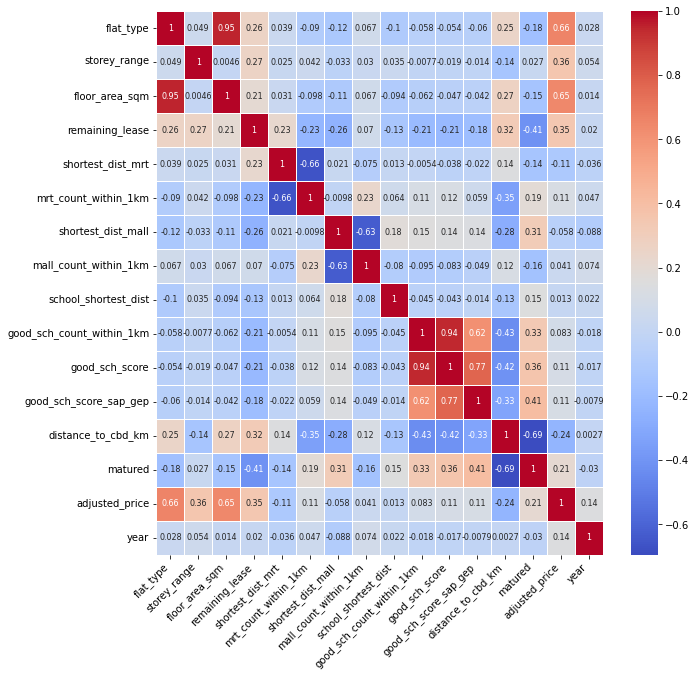

In [93]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
      cmap = 'coolwarm', linewidth=0.5, annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right')
fig.show()


High correlation (>0.6) between:

- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.68)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_ge and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)



If the largest VIF is greater than 10 then there is cause for concern (Bowerman & O’Connell, 1990; Myers, 1990)

If the average VIF is substantially greater than 1 then the regression may be biased (Bowerman & O’Connell, 1990).

Tolerance below 0.1 indicates a serious problem.

Tolerance below 0.2 indicates a potential problem (Menard, 1995).

In [94]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

vif_df = calc_vif(data.drop('adjusted_price',axis=1).select_dtypes(include=['int64','float64']))
vif_df

,variables,VIF,tolerance,meanVIF
0,flat_type,74.651187,0.013396,39.728449
1,storey_range,2.714313,0.368417,39.728449
2,floor_area_sqm,202.611396,0.004936,39.728449
3,remaining_lease,52.567984,0.019023,39.728449
4,shortest_dist_mrt,7.986464,0.125212,39.728449
5,mrt_count_within_1km,4.877482,0.205024,39.728449
6,shortest_dist_mall,7.689896,0.130041,39.728449
7,mall_count_within_1km,4.598744,0.217451,39.728449
8,school_shortest_dist,3.994117,0.250368,39.728449
9,good_sch_count_within_1km,17.923624,0.055792,39.728449


- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.68)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_ge and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)

between flat_type and floor_area_sqm, we will drop flat_type as floor_area_sqm could have more potential for feature explanation as it is a continuous variable, while flat_type has been label encoded.

For the mrt, mall, sch features, we will choose to drop the features that measure the count within 1km first, for reasons being the shortest distance features being continuous.

Between distance to cbd and matured features, we will drop matured as distance to cbd is a continous variable as well.

Between good_sch_score_sap_gep and good_sch_score, we will just drop good_sch_score_sap_gep for the time being. Depending on the results of the good_sch_score feature results, we will decide if there is reason to run the models again but with good_sch_score_sap_gep instead.

year variable is dropped as well, as we have already accounted for resale price inflation using CPI values. This should account for majority of the impact that year has on resale prices, due to the fact that generally why prices increases over time is due to inflation. It is also dropped for model simplicity.


In [95]:
dropped_features = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score_sap_gep',
                    'year']

calc_vif(data.drop(dropped_features,axis=1).
         drop('adjusted_price', axis = 1).
         select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,storey_range,2.696097,0.370907,9.178976
1,floor_area_sqm,17.109469,0.058447,9.178976
2,remaining_lease,27.623855,0.036201,9.178976
3,shortest_dist_mrt,4.372098,0.228723,9.178976
4,shortest_dist_mall,3.823602,0.261533,9.178976
5,school_shortest_dist,3.581283,0.279230,9.178976
6,good_sch_score,1.554635,0.643238,9.178976
7,distance_to_cbd_km,12.670766,0.078922,9.178976


We observe that remaining_lease and floor_area_sqm still has a very high VIF score, but we shall still keep these features as we feel they are important explainators of hdb resale price.

### Performance Measure

In [96]:
def model_performance(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print('R^2 score =', r2)
    print('MAE:', mae)
    print('RMSE', rmse)
    
    
    return(r2, mae, rmse)
    

### Train Test Split

In [97]:
df_1 = data.drop(columns = dropped_features)

# Split target variable from dataset
y= df_1['adjusted_price']
X = df_1.drop(columns='adjusted_price')


In [98]:
X

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
1,0,120.0,66.166667,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1,125.0,66.250000,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
3,7,162.0,66.333333,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,0,1,0,0,0,0,0,0
4,5,125.0,66.333333,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
5,5,125.0,66.750000,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200004,1,42.0,58.000000,0.373753,1.289185,0.076720,0,5.957048,0,0,...,0,0,0,0,0,0,0,0,0,1
200005,1,89.0,71.000000,0.570874,0.534437,0.461900,0,15.250503,0,0,...,1,0,0,0,0,0,0,0,1,0
200006,2,56.0,58.000000,0.403762,1.310129,0.084406,0,5.941265,0,0,...,0,0,0,0,0,0,0,0,0,1
200007,2,56.0,56.000000,0.576045,1.214740,0.333109,0,6.049047,0,0,...,0,0,0,0,0,0,0,0,0,1


In [99]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [100]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

156993 39249
156993 39249


### Feature Scaling

In [101]:
# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X_train_continuous = X_train[continuous_features]
X_train_continuous = scaler.fit_transform(X_train_continuous)

X_test_continuous = X_test[continuous_features]
X_test_continuous = scaler.transform(X_test_continuous)

# Replace original continuous features with scaled ones in X

X_train[continuous_features] = X_train_continuous
X_test[continuous_features] = X_test_continuous

In [102]:
X_train

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
39139,1,0.198815,0.375807,0.176287,-1.280533,0.039537,0,1.164178,0,0,...,0,0,0,0,1,0,0,0,0,0
27642,3,-1.258828,-1.262842,-0.121821,1.645394,-0.638008,3,-0.246012,1,0,...,0,0,0,0,0,0,1,0,0,0
40639,1,0.573638,0.233876,-1.129028,-1.004919,0.474606,0,1.083742,0,0,...,0,0,1,0,0,0,0,0,0,0
14571,1,-1.592004,-1.385419,0.102451,0.247817,0.106287,2,-0.586090,0,0,...,0,0,1,0,0,0,0,0,0,0
192021,1,1.823047,0.304842,0.582334,-1.320523,-0.704321,0,0.025211,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198171,3,0.865167,-1.075753,-0.283920,-0.420753,-0.319175,0,1.024091,0,0,...,0,0,1,0,0,0,0,0,0,0
68808,6,-0.300948,0.717730,-1.417836,-1.252072,-1.161653,0,-2.130701,0,0,...,0,0,0,0,1,0,0,0,0,0
80882,4,-0.217654,0.472577,-0.355805,-0.374877,1.515636,2,-0.956315,0,0,...,0,0,0,0,1,0,0,0,0,0
59161,1,-1.258828,-1.198329,-0.320513,1.274168,-0.290760,0,0.462593,0,0,...,0,0,0,0,0,0,1,0,0,0


In [103]:
X_test

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
145692,0,-1.258828,-0.830600,-0.461839,-0.097176,0.194282,0,0.166733,0,0,...,0,0,0,0,0,0,1,0,0,0
117950,1,0.115521,0.208071,-0.644967,-0.130610,1.212414,0,0.272251,0,0,...,0,0,0,0,1,0,0,0,0,0
170910,3,-1.550357,-0.643511,0.181352,0.928876,-0.954642,1,-0.525385,0,0,...,0,0,1,0,0,0,0,0,0,0
80393,12,-1.550357,0.846757,-1.416382,0.891459,-0.766257,0,-1.378433,0,0,...,0,0,0,0,1,0,0,0,0,0
117629,1,0.407050,0.311293,-0.732557,0.993448,0.191911,3,-0.270995,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144811,1,-0.300948,0.808049,1.625658,0.487433,0.158885,0,1.353009,0,0,...,0,0,0,0,1,0,0,0,0,0
59381,1,-0.967300,-1.275745,0.009586,-1.389039,0.061109,0,1.068422,0,0,...,0,0,1,0,0,0,0,0,0,0
178324,0,-0.967300,-0.275782,-1.323559,1.553511,-1.197346,0,0.558618,0,0,...,1,0,0,0,1,0,0,0,0,0
37558,3,-1.258828,1.562860,0.171666,-1.283176,-0.483473,0,0.506046,0,0,...,1,0,0,0,1,0,0,0,0,0


## Model Building

We have shortlisted the following models to understand the drivers of HDB resale prices:
1. Linear Regression
2. Random Forest (bootstrap method)
3. XGBoost (boosting method)

Linear regression is shortlisted as it provides a useful way to interpret the respective impacts that each feature has on the hdb resale price. We will be able to infer directionality of the impacts as well.

We want to also compare the performances of ensemble methods, which are non-parametric in nature. Specifically, we shortlisted one bagging (bootstrap aggregating) method, which will be Random Forest, and one boosting method, which will be XGBoost. From this, we will compare the performances between the models and investigate feature importance.

#### 1. Linear Regression

In [104]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae, lin_reg_rmse = model_performance(lr, X_train, X_test, y_train, y_test)

R^2 score = 0.8544864973157011
MAE: 44800.79411130913
RMSE 56809.67665065197


In [105]:
# if remove year:

# R^2 score = 0.6675238972331021
# Test loss (MAE): 0.15888490240356617

# if keep year:
# R^2 score = 0.8786545461139986
# Test loss (MAE): 0.08883246727760924

Let's plot the coefficients and observe their respective impacts on hdb resale price

In [106]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
22,town_MARINE PARADE,185742.707275
13,town_BUKIT TIMAH,179155.452480
1,floor_area_sqm,100994.224161
33,flat_model_DBSS,98893.258127
9,town_BISHAN,74757.599627
2,remaining_lease,62467.649914
25,town_QUEENSTOWN,57369.468232
35,flat_model_Maisonette,39492.131532
11,town_BUKIT MERAH,34485.642022
16,town_CLEMENTI,33274.606917


Let's also plot the OLS regression results, to look at the significance of the features.

In [107]:
X_constant = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_constant).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 2.190e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:13:39   Log-Likelihood:            -1.9422e+06
No. Observations:              156993   AIC:                         3.885e+06
Df Residuals:                  156950   BIC:                         3.885e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### 2. Random Forest 

Computing the baseline model for 

In [108]:
rf = RandomForestRegressor()
rf_r2, rf_mae, rf_rmse = model_performance(rf, X_train, X_test, y_train, y_test)

R^2 score = 0.9678971909356939
MAE: 19424.541564582512
RMSE 26683.462745935143


In [109]:
rf_importance = pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
1,floor_area_sqm,0.494561
7,distance_to_cbd_km,0.245617
2,remaining_lease,0.115412
0,storey_range,0.040596
3,shortest_dist_mrt,0.025610
4,shortest_dist_mall,0.019249
5,school_shortest_dist,0.009098
33,flat_model_DBSS,0.009021
13,town_BUKIT TIMAH,0.004090
6,good_sch_score,0.003932


#### Out-of-Bag

In [110]:
oob_model = RandomForestRegressor(oob_score=True)
oob_r2, oob_mae, oob_rmse = model_performance(oob_model, X_train, X_test, y_train, y_test)

R^2 score = 0.9680074183655423
MAE: 19392.30044572987
RMSE 26637.61350877567


In [111]:
oob_model.oob_score_

0.9672165656365544

In [112]:
oob_importance = pd.DataFrame(list(zip(oob_model.feature_names_in_, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
1,floor_area_sqm,0.494471
7,distance_to_cbd_km,0.245303
2,remaining_lease,0.115579
0,storey_range,0.040464
3,shortest_dist_mrt,0.025862
4,shortest_dist_mall,0.019052
33,flat_model_DBSS,0.009148
5,school_shortest_dist,0.009147
13,town_BUKIT TIMAH,0.004168
36,flat_model_Model A,0.004030


Hyperparameter tuning using RandomizedSearchCV

In [113]:
"""
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)

"""

"\nfrom sklearn.model_selection import RandomizedSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               }\nprint(random_grid)\n\n"

In [114]:
"""
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf1 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=100)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

"""


'\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf1 = RandomForestRegressor()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=100)\n# Fit the random search model\nrf_random.fit(X_train, y_train)\nprint(rf_random.best_params_)\n\n'

#### XGBoost

In [115]:
xgb = XGBRegressor()
xgb_r2, xgb_mae, xgb_rmse = model_performance(xgb, X_train, X_test, y_train, y_test)

R^2 score = 0.951966805540776
MAE: 24881.868653679332
RMSE 32639.342771628922


In [116]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
38,flat_model_New Generation,0.148289
1,floor_area_sqm,0.146112
33,flat_model_DBSS,0.110427
7,distance_to_cbd_km,0.094940
13,town_BUKIT TIMAH,0.051475
18,town_HOUGANG,0.033457
29,town_TAMPINES,0.029159
0,storey_range,0.028871
22,town_MARINE PARADE,0.028141
9,town_BISHAN,0.027804


## Other Analysis

#### swap good_sch_score with good_sch_score_SAP_GEP

In [117]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score',
                    'year']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

In [118]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

In [119]:
# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [121]:
lr2 = LinearRegression()
model_performance(lr2, X2_train, X2_test, y2_train, y2_test)

R^2 score = 0.8542826574080828
MAE: 44860.12183163728
RMSE 56849.45311960372


(0.8542826574080828, 44860.12183163728, 56849.45311960372)

In [124]:
lr_importance = pd.DataFrame(list(zip(lr2.feature_names_in_, lr2.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
22,town_MARINE PARADE,181517.101691
13,town_BUKIT TIMAH,173646.400437
1,floor_area_sqm,100878.618388
33,flat_model_DBSS,97735.448261
9,town_BISHAN,67056.232009
2,remaining_lease,62562.877139
25,town_QUEENSTOWN,57838.185157
35,flat_model_Maisonette,39260.274065
11,town_BUKIT MERAH,35829.524078
16,town_CLEMENTI,30898.459702


In [125]:
X2_constant = sm.add_constant(X2_train)
lr = sm.OLS(y2_train,X2_constant).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 2.186e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:28:49   Log-Likelihood:            -1.9423e+06
No. Observations:              156993   AIC:                         3.885e+06
Df Residuals:                  156950   BIC:                         3.885e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

good_sch_score_sap_gep coefficient is positive, which makes more intuitive sense

In [126]:
rf = RandomForestRegressor()
rf_r2, rf_mae, rf_rmse = model_performance(rf, X2_train, X2_test, y2_train, y2_test)

rf_importance = pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance.sort_values(by = 'Coeff', ascending = False)

R^2 score = 0.9678907574101094
MAE: 19435.306624577595
RMSE 26686.13634593088


,Features,Coeff
1,floor_area_sqm,0.493985
7,distance_to_cbd_km,0.245570
2,remaining_lease,0.115754
0,storey_range,0.041262
3,shortest_dist_mrt,0.025777
4,shortest_dist_mall,0.019454
5,school_shortest_dist,0.009134
33,flat_model_DBSS,0.009117
13,town_BUKIT TIMAH,0.004055
36,flat_model_Model A,0.004038


#### What if we remove floor_area_sqm, distance_to_cbd_km, and remaining_lease from the feature list?

In [136]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','floor_area_sqm','flat_type',
                    'good_sch_score', 'year', 'distance_to_cbd_km', 'remaining_lease']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [137]:
lr2 = LinearRegression()
model_performance(lr2, X2_train, X2_test, y2_train, y2_test)

lr_importance = pd.DataFrame(list(zip(lr2.feature_names_in_, lr2.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

R^2 score = 0.5288100094826909
MAE: 76984.75359046056
RMSE 102227.72547671774


,Features,Coeff
10,town_BUKIT TIMAH,153232.244342
6,town_BISHAN,122952.511095
19,town_MARINE PARADE,104122.654115
8,town_BUKIT MERAH,78536.229146
32,flat_model_Maisonette,47902.786764
25,town_SERANGOON,35113.111999
22,town_QUEENSTOWN,25890.986786
0,storey_range,22131.582840
13,town_CLEMENTI,20954.745050
30,flat_model_DBSS,7820.271129


In [138]:
rf = RandomForestRegressor()
rf_r2, rf_mae, rf_rmse = model_performance(rf, X2_train, X2_test, y2_train, y2_test)

rf_importance = pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance.sort_values(by = 'Coeff', ascending = False)

R^2 score = 0.864586107251744
MAE: 40109.43572032312
RMSE 54802.741105567875


,Features,Coeff
0,storey_range,0.145717
1,shortest_dist_mrt,0.127815
2,shortest_dist_mall,0.097113
32,flat_model_Maisonette,0.095887
3,school_shortest_dist,0.089085
35,flat_model_New Generation,0.061348
30,flat_model_DBSS,0.032459
4,good_sch_score_sap_gep,0.031213
8,town_BUKIT MERAH,0.030521
36,flat_model_Premium Apartment,0.025045
